<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/network_CVAE/network/CVAE/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/recipes_valid_0.pkl'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataPath = 'data/recipes_valid_0.pkl'

In [2]:
import pickle
import pandas as pd

with open(dataPath, 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())
print(len(pklData))

Index(['title', 'ingredients', 'instructions'], dtype='object')
100000


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
!pip install word2vec

     |████████████████████████████████| 42 kB 795 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=3591c5f1338e1124c0fe16fa803900036c78cf7e01775c3967817f5703020e3b
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [3]:
from ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor('/content/drive/MyDrive/TP2/Datasets/Recipe1M/vocab.bin')
#pklData = pklData[:2000]
out = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [4]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from ReciMeEncoder import ReciMeEncoder, RmeParameters
from ReciMeEncoder_unstacked import ReciMeEncoder_unstacked

# Import custom helper functions
from networkUtils import DataBuilder, standardize_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x).sum(axis=1)
        loss_MSE = loss_MSE.mean()
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), axis=1)
        loss_KLD = loss_KLD.mean()

        return loss_MSE, loss_KLD, loss_MSE + loss_KLD

In [8]:
loss = CustomLoss()

mat1 = torch.Tensor(np.zeros((1024,6400)))
mat2 = torch.Tensor(np.ones((1024,6400)))

mse, kld, l = loss(mat2, mat1, torch.tensor(np.zeros((1024,128))), torch.tensor(np.zeros((1024,128))))
mse.shape

torch.Size([])

### Setup Datasets + Hyperparameters

In [6]:
# One hot encoding without embedding and using sparse frame
train_data, test_data, scaler =  standardize_data(out)
batch_size = 512
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [7]:
params = RmeParameters(testdata_set.x.shape[1], 10000, 7000, 4000, 2500)

model = ReciMeEncoder(params).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

ReciMeEncoder(
  (encoderStack): Sequential(
    (0): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6360, out_features=10000, bias=True)
        (1): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=10000, out_features=7000, bias=True)
        (1): BatchNorm1d(7000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=7000, out_features=4000, bias=True)
        (1): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=4000, out_features=2500, bias=True)
        (1): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affin

### Train Model

In [8]:
epochs = 100
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []

In [12]:
def train_otherloss(epoch):
    model.train()
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss = loss_itm
        train_loss_MSE = loss_MSE.item()
        train_loss_KLD = loss_KLD.item()
        train_losses.append(train_loss)
        train_losses_MSE.append(train_loss_MSE)
        train_losses_KLD.append(train_loss_KLD)
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss, 
            train_loss_MSE , 
            train_loss_KLD))

In [13]:
def test_otherloss(epoch):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss = loss_itm
            test_loss_MSE = loss_MSE
            test_loss_KLD = loss_KLD
            test_losses.append(test_loss)
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss, 
                test_loss_MSE, 
                test_loss_KLD))

In [9]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE.item()
        train_loss_KLD += loss_KLD.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss / len(trainloader.dataset), 
            train_loss_MSE / len(trainloader.dataset), 
            train_loss_KLD / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        train_losses_MSE.append(train_loss_MSE / len(trainloader.dataset))
        train_losses_KLD.append(train_loss_KLD / len(trainloader.dataset))


In [10]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE.item()
            test_loss_KLD += loss_KLD.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset), 
                test_loss_MSE / len(testloader.dataset), 
                test_loss_KLD / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [11]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 10.84688, MSE: 10.36403, KLD: 0.48285
====> Epoch: 5 Average test loss: 11.0215, MSE: 10.6916, KLD: 0.3298
====> Epoch: 10 Average training loss: 10.51210, MSE: 10.15926, KLD: 0.35284
====> Epoch: 10 Average test loss: 12.3587, MSE: 12.0316, KLD: 0.3271
====> Epoch: 15 Average training loss: 10.24858, MSE: 10.07606, KLD: 0.17252
====> Epoch: 15 Average test loss: 11.1687, MSE: 11.0133, KLD: 0.1554
====> Epoch: 20 Average training loss: 9.97325, MSE: 9.86850, KLD: 0.10475
====> Epoch: 20 Average test loss: 12.3593, MSE: 12.2169, KLD: 0.1424
====> Epoch: 25 Average training loss: 10.00605, MSE: 9.88934, KLD: 0.11671
====> Epoch: 25 Average test loss: 10.0460, MSE: 9.9738, KLD: 0.0723
====> Epoch: 30 Average training loss: 9.54085, MSE: 9.48066, KLD: 0.06019
====> Epoch: 30 Average test loss: 10.0033, MSE: 9.9469, KLD: 0.0565
====> Epoch: 35 Average training loss: 9.83066, MSE: 9.73204, KLD: 0.09862
====> Epoch: 35 Average test loss: 10.0895, MSE: 9.9

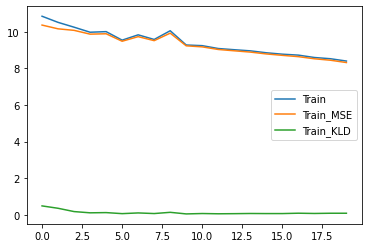

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])
#plt.ylim([0,100])

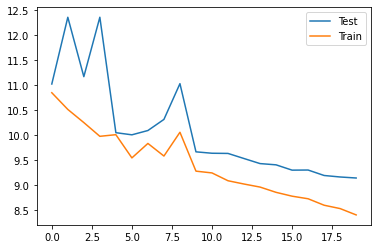

In [13]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [14]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [15]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [16]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data)

In [17]:
df_fake.head()

,0,1,2,3,4,5,6,7,8,9,...,6350,6351,6352,6353,6354,6355,6356,6357,6358,6359
0,-40.899158,13.102093,-73.577713,-82.653664,13.583007,26.483810,4.119952,12.353475,-8.538115,-25.258942,...,-0.038755,0.037693,0.020685,-0.040307,0.058093,-0.111225,-0.039768,-0.030146,-0.035825,0.073516
1,50.178753,3.940034,6.853186,15.064278,25.867081,-10.794014,-2.811655,5.676308,1.816841,18.201195,...,-0.019991,0.023966,0.015217,-0.021757,0.045798,-0.071661,-0.022350,-0.021869,-0.025966,0.047028
2,-52.502029,-50.674248,-40.677860,-31.987591,32.910072,-43.357807,7.553607,-9.793768,-17.457294,-5.863964,...,-0.026833,0.033370,0.016745,-0.035986,0.066069,-0.115142,-0.035795,-0.030272,-0.035018,0.078438
3,21.017576,8.196781,8.738047,10.651892,1.584730,0.864948,1.810024,2.500293,0.944762,5.853861,...,-0.021209,0.025383,0.017370,-0.025804,0.048614,-0.077501,-0.023757,-0.022041,-0.028485,0.051506
4,41.757931,8.138694,-6.592222,-3.561291,81.288490,-17.349588,18.657906,22.497259,26.508406,33.977726,...,-0.039651,0.037043,0.019965,-0.026270,0.068334,-0.099510,-0.037570,-0.030885,-0.031552,0.072102


In [18]:
print(fake_data.shape)
print(type(fake_data))

(20, 6360)
<class 'numpy.ndarray'>


In [19]:
def inverseOneHotEncoding(encoded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in encoded:
        rowTransformed = np.reshape(row, (20,-1))
        rowString = []
        indexTransformed = np.argmax(rowTransformed, axis=1) + 1
        for index in indexTransformed:
            if (index in dictionary.values()):
                rowString.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                rowString.append("")
        output.append(rowString)
    return np.array(output)

In [20]:
def inverseEmbedding(embedded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in embedded:
        outputRows = []
        for rowTransformed in np.reshape(row, (20,-1)):
            rowTransformed = torch.Tensor(rowTransformed)
            distance = torch.norm(preprocessor.emb.weight.data - rowTransformed, dim=1)
            nearest = torch.argmin(distance)
            index = nearest.item()
            if index:
                outputRows.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                outputRows.append("")
        output.append(outputRows)

    return np.array(output)

In [21]:
def decodeOutput(output: np.ndarray):
    # Split output into amounts, units and ingredients 
    amounts = output[:, :20]
    amountColumns = ['amount_' + str(sub) for sub in list(range(0,20))]
    units = output[:, 20:len(preprocessor.unitDict)*20+20]
    unitColumns = ['unit_' + str(sub) for sub in list(range(0,20))]
    ingredients = output[:, len(preprocessor.unitDict)*20+20:]
    ingredientColumns = ['ingredient_' + str(sub) for sub in list(range(0,20))]
    unitsDecoded = inverseOneHotEncoding(units, preprocessor.unitDict)
    ingredientsDecoded = inverseEmbedding(ingredients, preprocessor.ingredientDict)
    outputFrame = []
    for index in range(len(amounts)):
        array = np.stack((amounts[index], unitsDecoded[index], ingredientsDecoded[index]),axis=1)
        outputFrame.append(pd.DataFrame(array, columns=["amount", "unit", "ingredient"]))
    return outputFrame

df = decodeOutput(fake_data)
df[0]

,amount,unit,ingredient
0,-40.89916,pound-mass,eggs
1,13.102093,cup,brown_sugar
2,-73.57771,,flour
3,-82.65366,,onions
4,13.583007,,garlic_cloves
5,26.48381,teaspoon,pepper
6,4.1199517,teaspoon,fistful
7,12.353475,cup,nor
8,-8.538115,cup,vanilla_extract
9,-25.258942,cup,


In [60]:
data = pklData[:1]['ingredients']

dataEmbedded = np.array(preprocessor.preProcessInput(data))

y, mu, logvar = model(dataEmbedded)


dataReconverted = decodeOutput(dataEmbedded)
pd.concat([dataReconverted[0], data[0].add_prefix("orig_")], axis=1)

TypeError: ignored

In [ ]:
string = "dry dill weed"
name_words = string.lower().split(' ')
for i in range(len(name_words)):
    print('_'.join(name_words[i:]))

dry_dill_weed
dill_weed
weed


In [ ]:
embeddings = torch.nn.Embedding(1000, 100)
my_sample = torch.randn(1, 100)
distance = torch.norm(embeddings.weight.data - my_sample, dim=1)
nearest = torch.argmin(distance)
print(my_sample.shape)
print(embeddings.weight.data.shape)

torch.Size([1, 100])
torch.Size([1000, 100])


In [ ]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

NameError: ignored

In [ ]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)